In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D
from scipy.stats import wasserstein_distance

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Create anisotropic Gaussian

In [47]:
mean = torch.tensor([0.5, 0.5])
std  = torch.tensor([0.1, 0.05])
num_points = 3000

gaussian = mean + std * torch.randn(num_points, 2)

(0.0, 1.0)

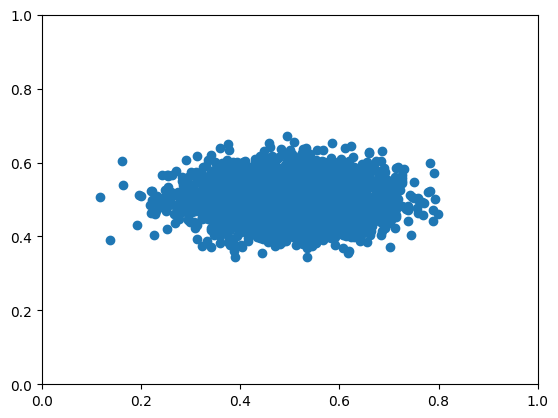

In [48]:
plt.scatter(gaussian[:,0], gaussian[:,1])
plt.xlim(0,1)
plt.ylim(0,1)

In [49]:
training_seq = gaussian.unsqueeze(-1)

# Train

In [50]:
num_epochs = 10000
mode = 'sampling'

In [51]:
model = Unet1D(
    dim = 64,
    dim_mults = (1, ),
    channels = 2
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 1,
    timesteps = 100,
    objective = 'pred_noise'
)

# Using trainer

dataset = Dataset1D(training_seq)  # this is just an example, but you can formulate your own Dataset and pass it into the `Trainer1D` below

trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = num_epochs,         # total training steps
    save_and_sample_every = 100000, # gets saved to "results" folder (disable with high save_and_sample_every)
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)

if mode == "training":
    trainer.train()

    torch.save(
        model.state_dict(),
        f"model_checkpoints/riemann/{num_epochs}_aniso.pt"
    ) 

if mode == "sampling":
    state_dict = torch.load(f"model_checkpoints/riemann/{num_epochs}_aniso.pt", map_location="cpu")
    model.load_state_dict(state_dict)


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [52]:
def sample_density_2d(samples, tau, bins=100, levels=10):

    samples = samples.squeeze(-1).detach().cpu().numpy()

    x = samples[:, 0]
    y = samples[:, 1]

    # Empirical density
    hist, xedges, yedges = np.histogram2d(
        x, y,
        bins=bins,
        range=[[-1, 1], [-1, 1]],
        density=True
    )

    xc = 0.5 * (xedges[:-1] + xedges[1:])
    yc = 0.5 * (yedges[:-1] + yedges[1:])
    Xc, Yc = np.meshgrid(xc, yc, indexing="ij")

    plt.figure(figsize=(6, 5))

    # Heatmap
    plt.imshow(
        hist.T,
        origin="lower",
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        aspect="equal",
        cmap="Grays",
    )

    mu_x, mu_y = 0.5, 0.5

    Z_true = (
        1.0 / (2.0 * np.pi * std[0] * std[1])
        * np.exp(
            -0.5 * (
                ((Xc - mu_x) ** 2) / std[0]**2
                + ((Yc - mu_y) ** 2) / std[1]**2
            )
        )
    )


    # Contours of true density
    plt.contour(
        Xc, Yc, Z_true,
        levels=levels,
        cmap="rainbow",
        linewidths=0.5,
    )
   

    plt.xlabel("x",fontsize = 'large')
    plt.ylabel("y",fontsize = 'large')
    plt.xlim(0,1)
    plt.ylim(0,1)
    if tau == 1.0:
        plt.title("Our EBM Samples", fontsize = 'large')
    elif tau == 0.0:
        plt.title("Standard EBM Samples", fontsize = 'large')

    plt.tight_layout()
    plt.show()


In [53]:
def sample_density_2d_grid(
    taus,
    training_seq,
    diffusion,
    num_points,
    std,
    bins=100,
    levels=10,
):
    """
    taus: list or 1D tensor of tau values (excluding training plot)
    training_seq: (N, 2, 1) or (N, 2) tensor
    """

    # ---- prepare training data ----
    train_xy = training_seq.squeeze(-1).detach().cpu().numpy()
    train_x = train_xy[:, 0]
    train_y = train_xy[:, 1]

    ncols = len(taus) + 1
    fig, axes = plt.subplots(
        1, ncols, figsize=(4.2 * ncols, 4.5), sharex=True, sharey=True
    )

    mu_x, mu_y = 0.5, 0.5

    def plot_panel(ax, x, y, title):
        hist, xedges, yedges = np.histogram2d(
            x, y,
            bins=bins,
            range=[[0, 1], [0, 1]],
            density=True
        )

        xc = 0.5 * (xedges[:-1] + xedges[1:])
        yc = 0.5 * (yedges[:-1] + yedges[1:])
        Xc, Yc = np.meshgrid(xc, yc, indexing="ij")

        # darker histogram
        ax.imshow(
            hist.T,
            origin="lower",
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            aspect="equal",
            cmap="gray_r",
            alpha=0.95,
        )

        # true density (lighter contours)
        Z_true = (
            1.0 / (2.0 * np.pi * std[0] * std[1])
            * np.exp(
                -0.5 * (
                    ((Xc - mu_x) ** 2) / std[0]**2
                    + ((Yc - mu_y) ** 2) / std[1]**2
                )
            )
        )

        ax.contour(
            Xc, Yc, Z_true,
            levels=levels,
            colors="tab:blue",
            linewidths=0.6,
            alpha=0.45,
        )

        ax.set_title(title, fontsize="large")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

    # ---- leftmost: training data ----
    plot_panel(
        axes[0],
        train_x,
        train_y,
        title="Training data"
    )

    axes[0].set_ylabel("y", fontsize="large")

    # ---- sampled panels ----
    for i, tau in enumerate(taus):
        sampled_seq = diffusion.sample(
            k=1.0,
            k_cns=1.0,
            tau=float(tau),
            n_chunks=10,
            batch_size=num_points
        )

        samp_xy = sampled_seq.squeeze(-1).detach().cpu().numpy()
        samp_x = samp_xy[:, 0]
        samp_y = samp_xy[:, 1]

        plot_panel(
            axes[i + 1],
            samp_x,
            samp_y,
            title=f"$\\tau = {float(tau):.2f}$"
        )

    for ax in axes:
        ax.set_xlabel("x", fontsize="large")

    plt.tight_layout()
    plt.show()


In [54]:
taus = torch.linspace(0.0, 3.0, steps=5)

/tmp/ipykernel_1074415/2701767501.py:52: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  * np.exp(


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

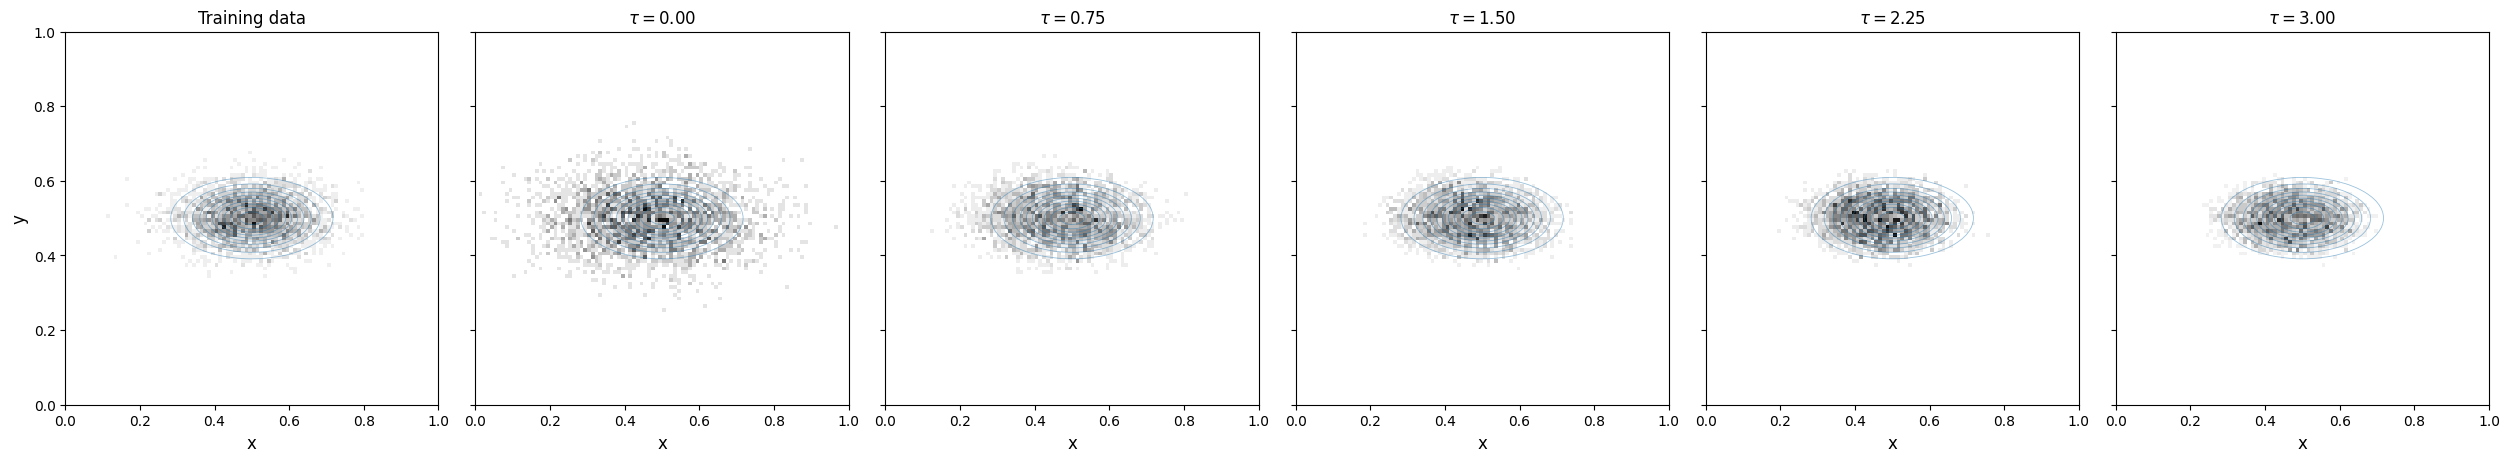

In [55]:
sample_density_2d_grid(
    taus,
    training_seq,
    diffusion,
    num_points,
    std,
    bins=100,
    levels=10,
)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

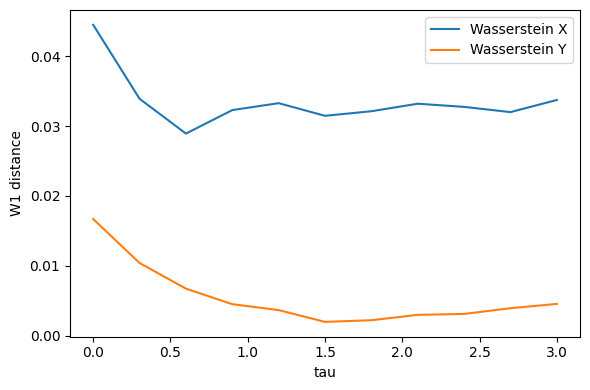

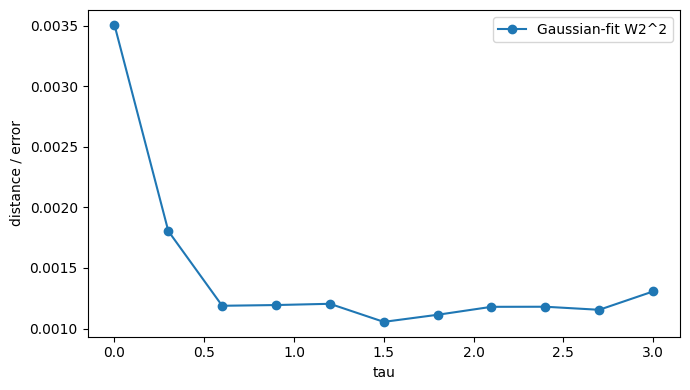

In [56]:
taus = torch.linspace(0.0, 3.0, steps=11)

# containers
W_x = []
W_y = []
W2_sq = []
cov_xy_abs = []
mean_err = []

# training data (fixed)
training_np = training_seq.squeeze(-1).detach().cpu().numpy()
train_x = training_np[:, 0]
train_y = training_np[:, 1]

# target Gaussian
mu_t = torch.tensor([0.5, 0.5])
std_t = torch.tensor([0.1, 0.05])
cov_t = torch.diag(std_t**2)

def cov_and_mean(xy: torch.Tensor):
    xy = xy.detach()
    mu = xy.mean(dim=0)
    xc = xy - mu
    cov = (xc.T @ xc) / (xy.shape[0] - 1)
    return mu, cov

def sqrtm_psd_2x2(A: np.ndarray):
    w, V = np.linalg.eigh(A)
    w = np.clip(w, 0, None)
    return (V * np.sqrt(w)) @ V.T

def w2_gaussian(mu1, S1, mu2, S2):
    mu1 = np.asarray(mu1); mu2 = np.asarray(mu2)
    S1 = np.asarray(S1); S2 = np.asarray(S2)
    S2h = sqrtm_psd_2x2(S2)
    M = S2h @ S1 @ S2h
    Mh = sqrtm_psd_2x2(M)
    return np.sum((mu1 - mu2)**2) + np.trace(S1 + S2 - 2 * Mh)  # W2^2

for tau in taus:
    sampled_seq = diffusion.sample(
        k=1.0,
        k_cns=1.0,
        tau=float(tau),
        n_chunks=10,
        batch_size=num_points
    )

    samp_xy = sampled_seq.squeeze(-1)  # (N, 2)
    samples_np = samp_xy.detach().cpu().numpy()

    samp_x = samples_np[:, 0]
    samp_y = samples_np[:, 1]

    # W1 marginals
    W_x.append(wasserstein_distance(samp_x, train_x))
    W_y.append(wasserstein_distance(samp_y, train_y))

    # Gaussian diagnostics
    mu_s, cov_s = cov_and_mean(samp_xy)

    device = samp_xy.device
    mu_t_dev = mu_t.to(device)
    cov_t_dev = cov_t.to(device)

    cov_xy_abs.append(abs(cov_s[0, 1].item()))
    mean_err.append(torch.norm(mu_s - mu_t_dev).item())

    W2_sq.append(
        w2_gaussian(
            mu_s.cpu().numpy(), cov_s.cpu().numpy(),
            mu_t.cpu().numpy(), cov_t.cpu().numpy()
        )
    )

# ---- plots ----

plt.figure(figsize=(6, 4))
plt.plot(taus, W_x, label="Wasserstein X")
plt.plot(taus, W_y, label="Wasserstein Y")
plt.xlabel("tau")
plt.ylabel("W1 distance")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(taus, W2_sq, marker="o", label="Gaussian-fit W2^2")
# plt.plot(taus, cov_xy_abs, marker="o", label="|Cov_xy|")
# plt.plot(taus, mean_err, marker="o", label="||mean error||")
plt.xlabel("tau")
plt.ylabel("distance / error")
plt.legend()
plt.tight_layout()
plt.show()
